In [222]:
# All of the imports that are going to be used throughout the model
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import joblib

from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer, LabelEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

In [223]:
df = pd.read_csv("https://raw.githubusercontent.com/Mik-Nowak-05/Alzheimers_Disease_Prediction_Model/refs/heads/main/alzheimers_disease_data.csv")
df.head()

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid


In [224]:
df.shape

(2149, 35)

In [225]:
df = df.drop(['PatientID', 'DoctorInCharge'], axis=1) # Dropping the Columns that have IDs or Data that is unpredictable
df.shape

(2149, 33)

In [226]:
df.isnull().sum() # No null values

Age                          0
Gender                       0
Ethnicity                    0
EducationLevel               0
BMI                          0
Smoking                      0
AlcoholConsumption           0
PhysicalActivity             0
DietQuality                  0
SleepQuality                 0
FamilyHistoryAlzheimers      0
CardiovascularDisease        0
Diabetes                     0
Depression                   0
HeadInjury                   0
Hypertension                 0
SystolicBP                   0
DiastolicBP                  0
CholesterolTotal             0
CholesterolLDL               0
CholesterolHDL               0
CholesterolTriglycerides     0
MMSE                         0
FunctionalAssessment         0
MemoryComplaints             0
BehavioralProblems           0
ADL                          0
Confusion                    0
Disorientation               0
PersonalityChanges           0
DifficultyCompletingTasks    0
Forgetfulness                0
Diagnosi

In [227]:
cat_df = df.select_dtypes(include=[object]) # Checking whether categorical columns exist inside the data frame
cat_df.describe

<bound method NDFrame.describe of Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[2149 rows x 0 columns]>

In [228]:
z_scores = np.abs(stats.zscore(df, nan_policy='omit')) # Calculating the z-scores

z_scores_df = pd.DataFrame(z_scores, columns=df.columns, index=df.index) # Converting back to the DataFrame so that we can use it later
z_mean_per_row = z_scores_df.mean(axis=1) # Mean z-score per row

z_mean_per_row.describe()

count    2149.000000
mean        0.829316
std         0.096439
min         0.538495
25%         0.760568
50%         0.824161
75%         0.892383
max         1.174333
dtype: float64

In [229]:
Q1 = z_scores_df.quantile(0.25) # Compute the lower Q1
Q3 = z_scores_df.quantile(0.75) # Computer the upper Q3
IQR = Q3 - Q1 # Calculate the IQR, as we will need that for outlier boundaries

lower_bound = Q1 - 1.5 * IQR # Defining lower bound for outlier
upper_bound = Q3 + 1.5 * IQR # Defining upper bound for outlier

outliers = (z_scores_df < lower_bound) | (z_scores_df > upper_bound) # Identifying outlier cells per column based on the above bounds

outlier_fraction = outliers.mean(axis=1) # Calculating fractions of the outlier values for each row

df_outliers = df[outlier_fraction >= 0.5] # Dropping rows that are >= 50% filled with outliers

In [230]:
df_outliers.shape # No outliers inside the dataset that would fill the threshold of 50%

(0, 33)

In [231]:
corr = df.corr(numeric_only=True)['Diagnosis'].sort_values(ascending=False) # Computing the correlations with the target variable,
                                                                                            # i.e. Diagnosis for better insight
print(corr)

Diagnosis                    1.000000
MemoryComplaints             0.306742
BehavioralProblems           0.224350
CholesterolHDL               0.042584
Hypertension                 0.035080
CardiovascularDisease        0.031490
BMI                          0.026343
CholesterolTriglycerides     0.022672
DifficultyCompletingTasks    0.009069
DietQuality                  0.008506
CholesterolTotal             0.006394
PhysicalActivity             0.005945
DiastolicBP                  0.005293
Forgetfulness               -0.000354
Smoking                     -0.004865
Age                         -0.005488
Depression                  -0.005893
AlcoholConsumption          -0.007618
Ethnicity                   -0.014782
SystolicBP                  -0.015615
Confusion                   -0.019186
PersonalityChanges          -0.020627
Gender                      -0.020975
HeadInjury                  -0.021411
Disorientation              -0.024648
Diabetes                    -0.031508
CholesterolL

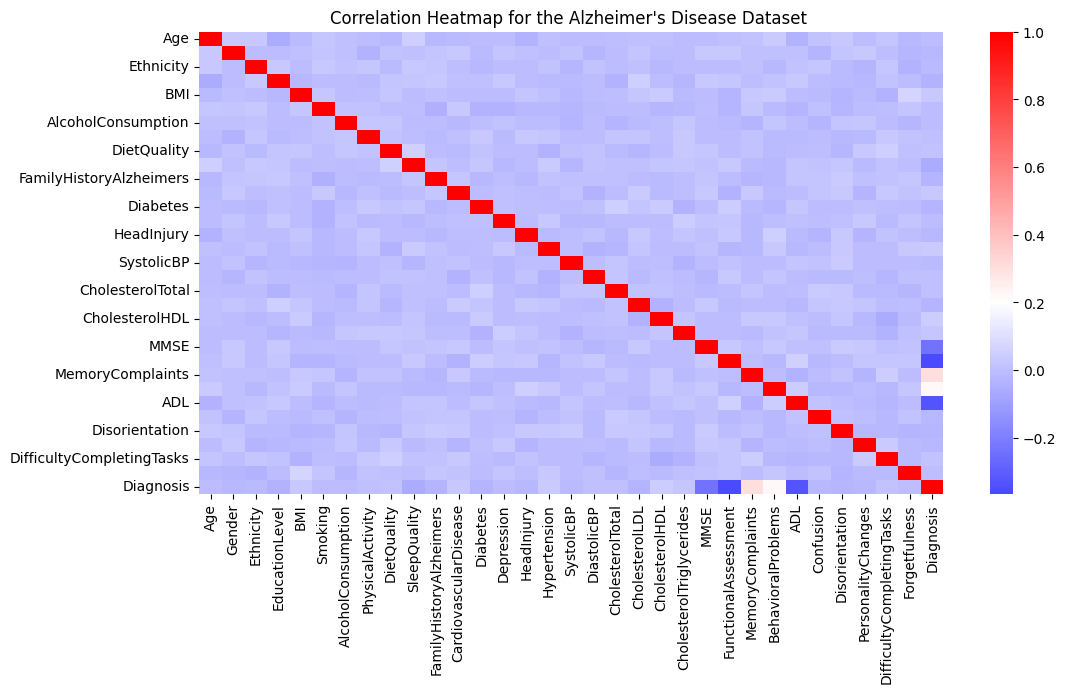

In [232]:
# Correlation heatmap for visualisation
heatmap = df.corr(numeric_only=True) 

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap, cmap='bwr', annot=False, center=0.2)
plt.title('Correlation Heatmap for the Alzheimer\'s Disease Dataset ')
plt.show()

In [233]:
df = df.drop(['DietQuality', 'CholesterolTotal', 'Ethnicity', 'Gender', 'CholesterolLDL', 'CholesterolTriglycerides'], axis=1) 
# After looking at the correlations, we can see that these features can be dropped,
# Many lifestyle features are not correlated; however, they might be important in the prediction.

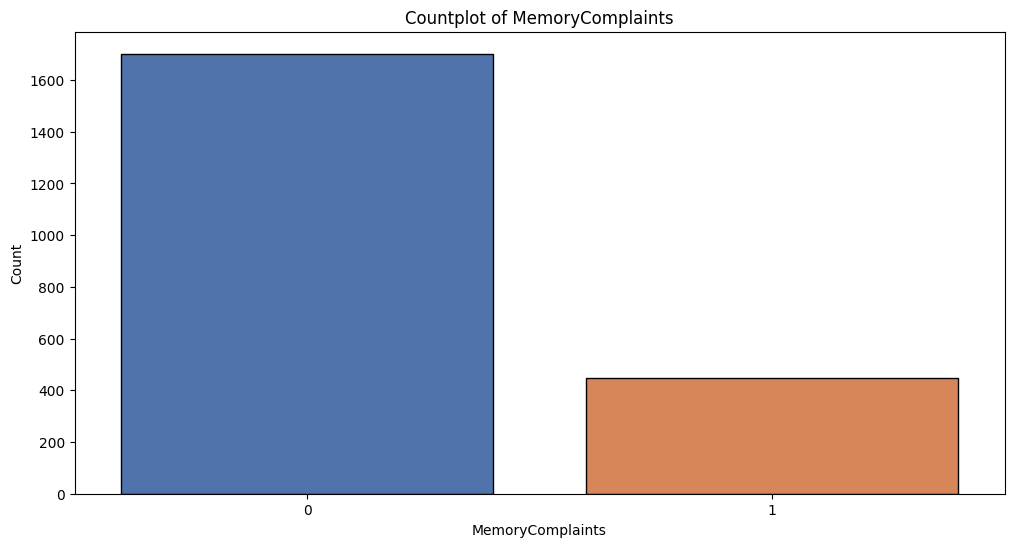

In [234]:
# Taking a look at some of the highly correlated binary features:
# 1) MemoryComplaints
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="MemoryComplaints", hue="MemoryComplaints", palette="deep", edgecolor="black", saturation=0.9, legend=False)
plt.title("Countplot of MemoryComplaints")
plt.xlabel("MemoryComplaints")
plt.ylabel("Count")
plt.show()

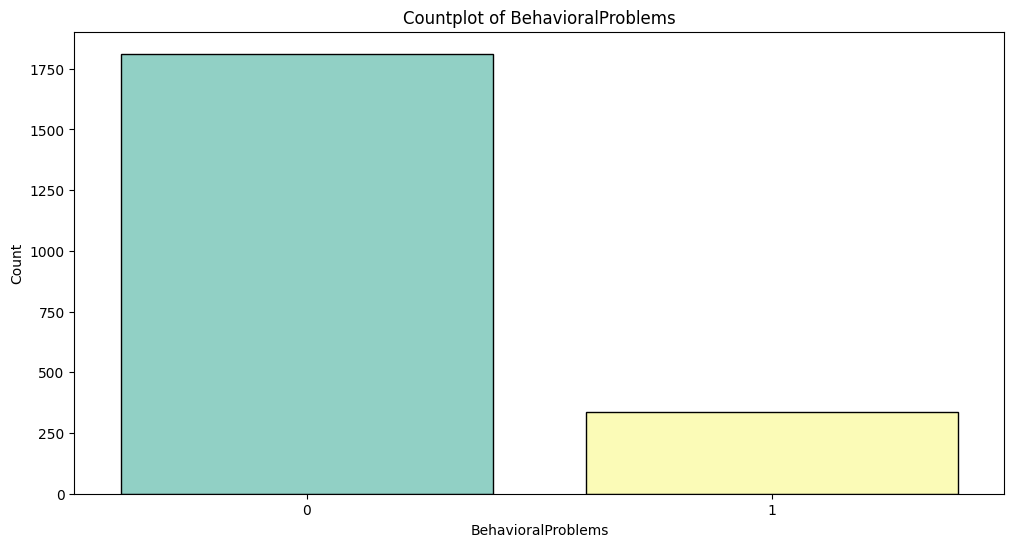

In [235]:
# 2) BehavioralProblems 
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="BehavioralProblems", hue="BehavioralProblems", palette="Set3", edgecolor="black", saturation=0.9, legend=False)
plt.title("Countplot of BehavioralProblems")
plt.xlabel("BehavioralProblems")
plt.ylabel("Count")
plt.show()

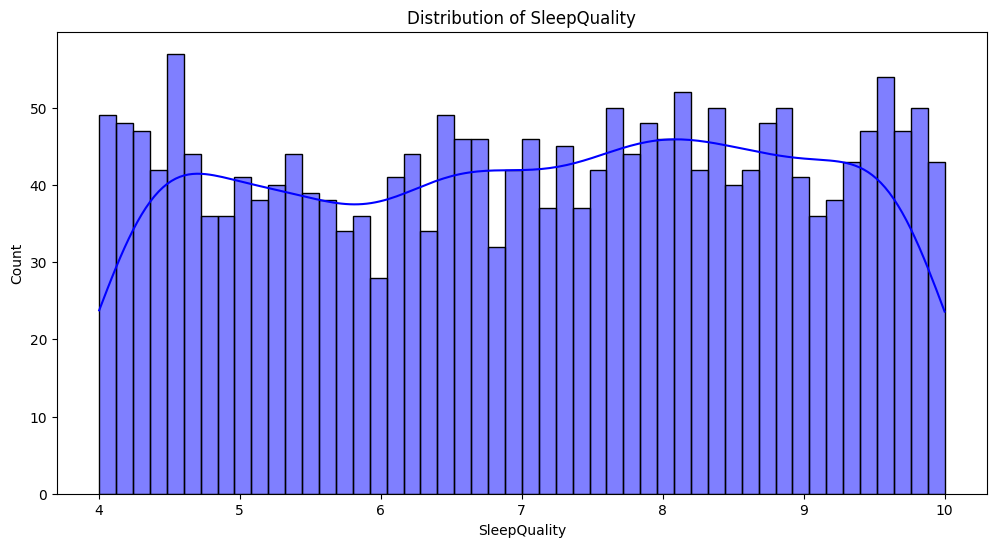

In [236]:
# Taking a look at some distributions of the non-binary features:
# 1) Distribution of SleepQuality
plt.figure(figsize=(12, 6))
sns.histplot(df["SleepQuality"], bins=50, kde=True, color="blue")
plt.title("Distribution of SleepQuality")
plt.xlabel("SleepQuality")
plt.ylabel("Count")
plt.show()

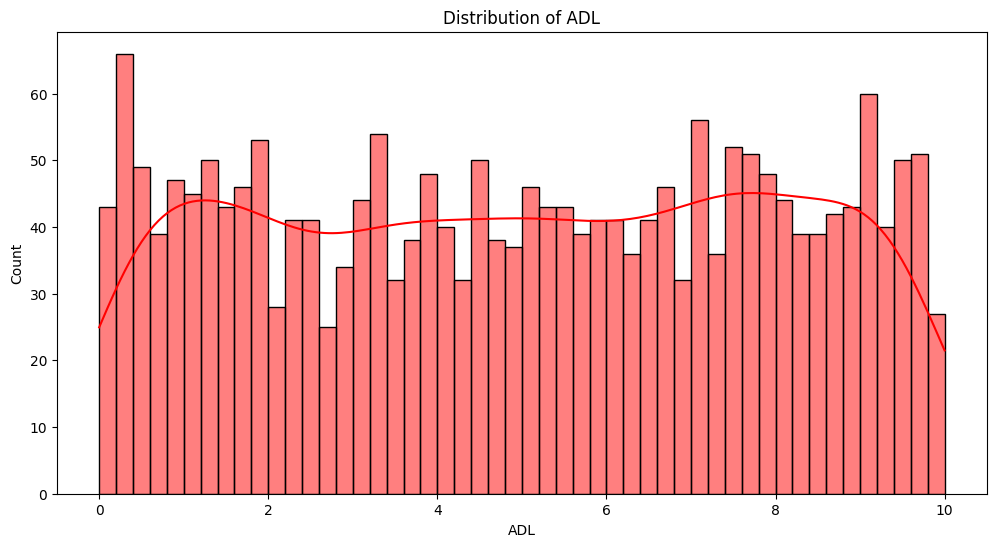

In [237]:
# 2) Distribution of ADL
plt.figure(figsize=(12, 6))
sns.histplot(df["ADL"], bins=50, kde=True, color="red")
plt.title("Distribution of ADL")
plt.xlabel("ADL")
plt.ylabel("Count")
plt.show()

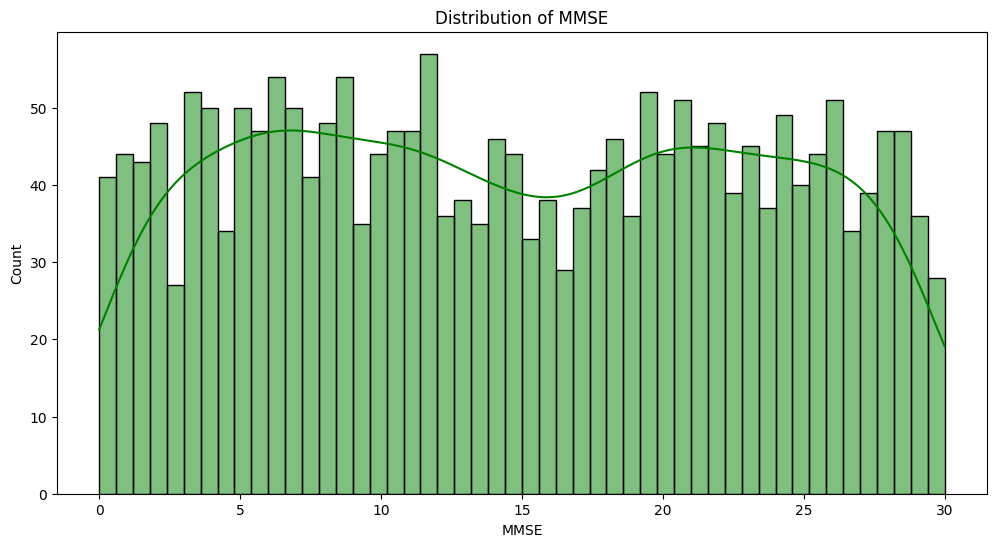

In [238]:
# 3) Distribution of MMSE
plt.figure(figsize=(12, 6))
sns.histplot(df["MMSE"], bins=50, kde=True, color="green")
plt.title("Distribution of MMSE")
plt.xlabel("MMSE")
plt.ylabel("Count")
plt.show()

In [239]:
# Splitting data into train and test
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [240]:
# Scaling for both PCA and K-Means
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)

In [241]:
# PCA
pca = PCA(n_components=0.95)

X_train_pca = pca.fit_transform(X_train_scaled)
print(f"Components Kept: {pca.n_components_}")

Components Kept: 25


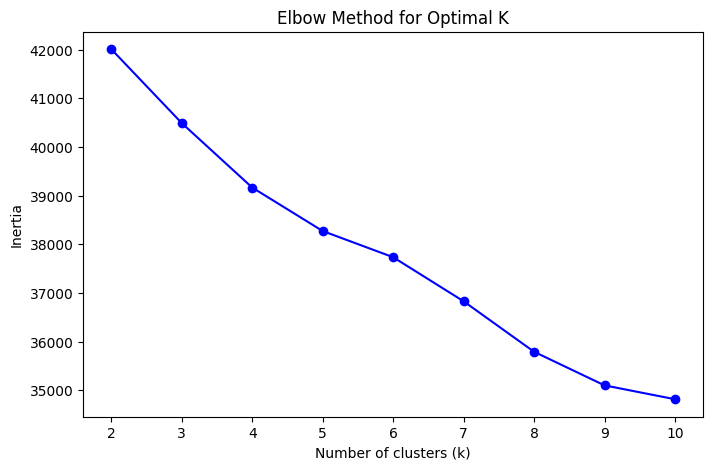

In [242]:
# For K-Means Clustering, finding the optimal K with the Elbow Method
inertia = []
K = range(2, 11) # Since the data set is quite small, testing with 2-10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_pca)
    inertia.append(kmeans.inertia_)
    
# Plotting the Elbow Method
plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

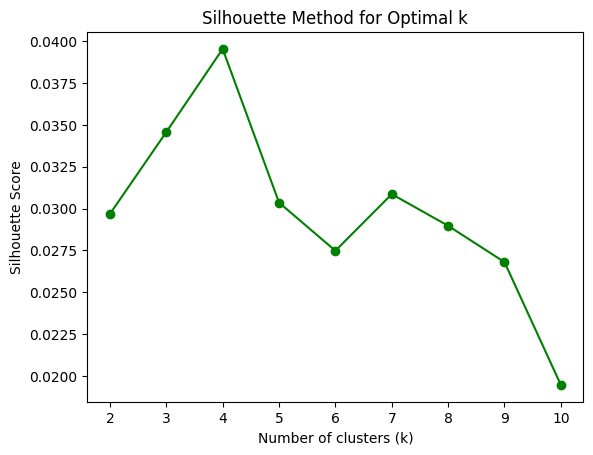

In [243]:
# For K-Mean Clustering, finding the optimal K with the Silhouette Method
scores = []
K = range(2, 11) # Once again as above, 2-10 clusters

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_train_pca)
    scores.append(silhouette_score(X_train_pca, labels))

plt.plot(K, scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [244]:
# We can see that the most optimum K is 4; therefore, now we construct the main pipeline for preprocessing with Scaler, PCA, and KMeans
# Pipeline:
pca_kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('kmeans', KMeans(n_clusters=4, random_state=42))
])

pca_kmeans_pipeline.fit(X_train) # Fit to the training data

train_clusters = pca_kmeans_pipeline.predict(X_train) # Extracting the clusters for both test and train
test_clusters  = pca_kmeans_pipeline.predict(X_test)

X_train_clustered = X_train.copy() # Adding the cluster information as new features, so we can use them for the actual Classification Models
X_train_clustered['Cluster'] = train_clusters

X_test_clustered = X_test.copy()
X_test_clustered['Cluster'] = test_clusters

In [245]:
# Trying out the Random Forest Classifier
random_forest = RandomForestClassifier(random_state=42)

random_forest.fit(X_train_clustered, y_train)

y_pred = random_forest.predict(X_test_clustered)

# Testing the Predictions
print("----------------------------------------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("----------------------------------------------------------")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n----------------------------------------------------------")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("----------------------------------------------------------")

----------------------------------------------------------
Accuracy: 0.9395348837209302
Precision: 0.9635036496350365
Recall: 0.8627450980392157
F1 Score: 0.9103448275862069
----------------------------------------------------------

Confusion Matrix:
 [[272   5]
 [ 21 132]]

----------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.98      0.95       277
           1       0.96      0.86      0.91       153

    accuracy                           0.94       430
   macro avg       0.95      0.92      0.93       430
weighted avg       0.94      0.94      0.94       430

----------------------------------------------------------


In [246]:
# Realised that the scores are great, apart from the Recall which I would like to be higher
# Using RandomizedSearchCV to fine-tune the Random Forest Classifier
params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 15, 20, 30],
    'min_samples_split': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5],
    'max_features': ['sqrt', 'log2', 0.5, None],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample']
}

random_forest_cv = RandomizedSearchCV(
    estimator=random_forest,
    param_distributions=params,
    n_iter=50,
    scoring='recall', # Optimising the Recall
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_forest_cv.fit(X_train_clustered, y_train)

# Checking the best parameters:
print("----------------------------------------------------------")
print("Best Recall Score (CV):", random_forest_cv.best_score_)
print("----------------------------------------------------------")
print("\nBest Parameters:\n", random_forest_cv.best_params_)
print("----------------------------------------------------------")

Fitting 5 folds for each of 50 candidates, totalling 250 fits
----------------------------------------------------------
Best Recall Score (CV): 0.9209185747188728
----------------------------------------------------------

Best Parameters:
 {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': None, 'max_depth': 10, 'class_weight': 'balanced', 'bootstrap': True}
----------------------------------------------------------


In [247]:
# Trying the Fine-tuned Random Forest Classifier
random_forest_tuned = RandomForestClassifier(
    n_estimators=200,
    min_samples_split=2,
    min_samples_leaf=3,
    max_features=None,
    max_depth=10,
    class_weight='balanced',
    bootstrap=True,
    random_state=42
)

random_forest_tuned.fit(X_train_clustered, y_train)

y_pred = random_forest_tuned.predict(X_test_clustered)

# Testing the Predictions
print("----------------------------------------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("----------------------------------------------------------")
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n----------------------------------------------------------")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("----------------------------------------------------------")

----------------------------------------------------------
Accuracy: 0.9558139534883721
Precision: 0.9527027027027027
Recall: 0.9215686274509803
F1 Score: 0.9368770764119602
----------------------------------------------------------

Confusion Matrix:
 [[270   7]
 [ 12 141]]

----------------------------------------------------------

Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.97      0.97       277
           1       0.95      0.92      0.94       153

    accuracy                           0.96       430
   macro avg       0.96      0.95      0.95       430
weighted avg       0.96      0.96      0.96       430

----------------------------------------------------------


In [248]:
# Joblib for Usage in Production
joblib.dump(pca_kmeans_pipeline, "pca_kmeans_pipeline.pkl") # Saving the Pipeline for production (includes StandardScaler, PCA, and KMeans)
joblib.dump(random_forest_tuned, "random_forest_model_tuned.pkl") # Saving the fine-tuned model for production (Overall Accuracy of ~96%)

['random_forest_model_tuned.pkl']